# Contents: <a class="anchor" id="top"></a>
### [Part A: Preprocessing & EDA](#p1)
### [Part B: Model Development](#p2) 
### [Part C: Numerical Stability Experiment](#p3) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
from numpy.linalg import inv 
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

dataset link: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data

column definitions:
id - Unique ID for each home sold  
date - Date of the home sale  
price - Price of each home sold  
bedrooms - Number of bedrooms  
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower  
sqft_living - Square footage of the apartments interior living space  
sqft_lot - Square footage of the land space  
floors - Number of floors  
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not  
view - An index from 0 to 4 of how good the view of the property was  
condition - An index from 1 to 5 on the condition of the apartment,  
grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.  
sqft_above - The square footage of the interior housing space that is above ground level  
sqft_basement - The square footage of the interior housing space that is below ground level  
yr_built - The year the house was initially built  
yr_renovated - The year of the house’s last renovation  
zipcode - What zipcode area the house is in  
lat - Lattitude  
long - Longitude  
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors  
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

# Part A: Preprocessing & EDA <a class="anchor" id="p1"></a>
[back to top](#top)

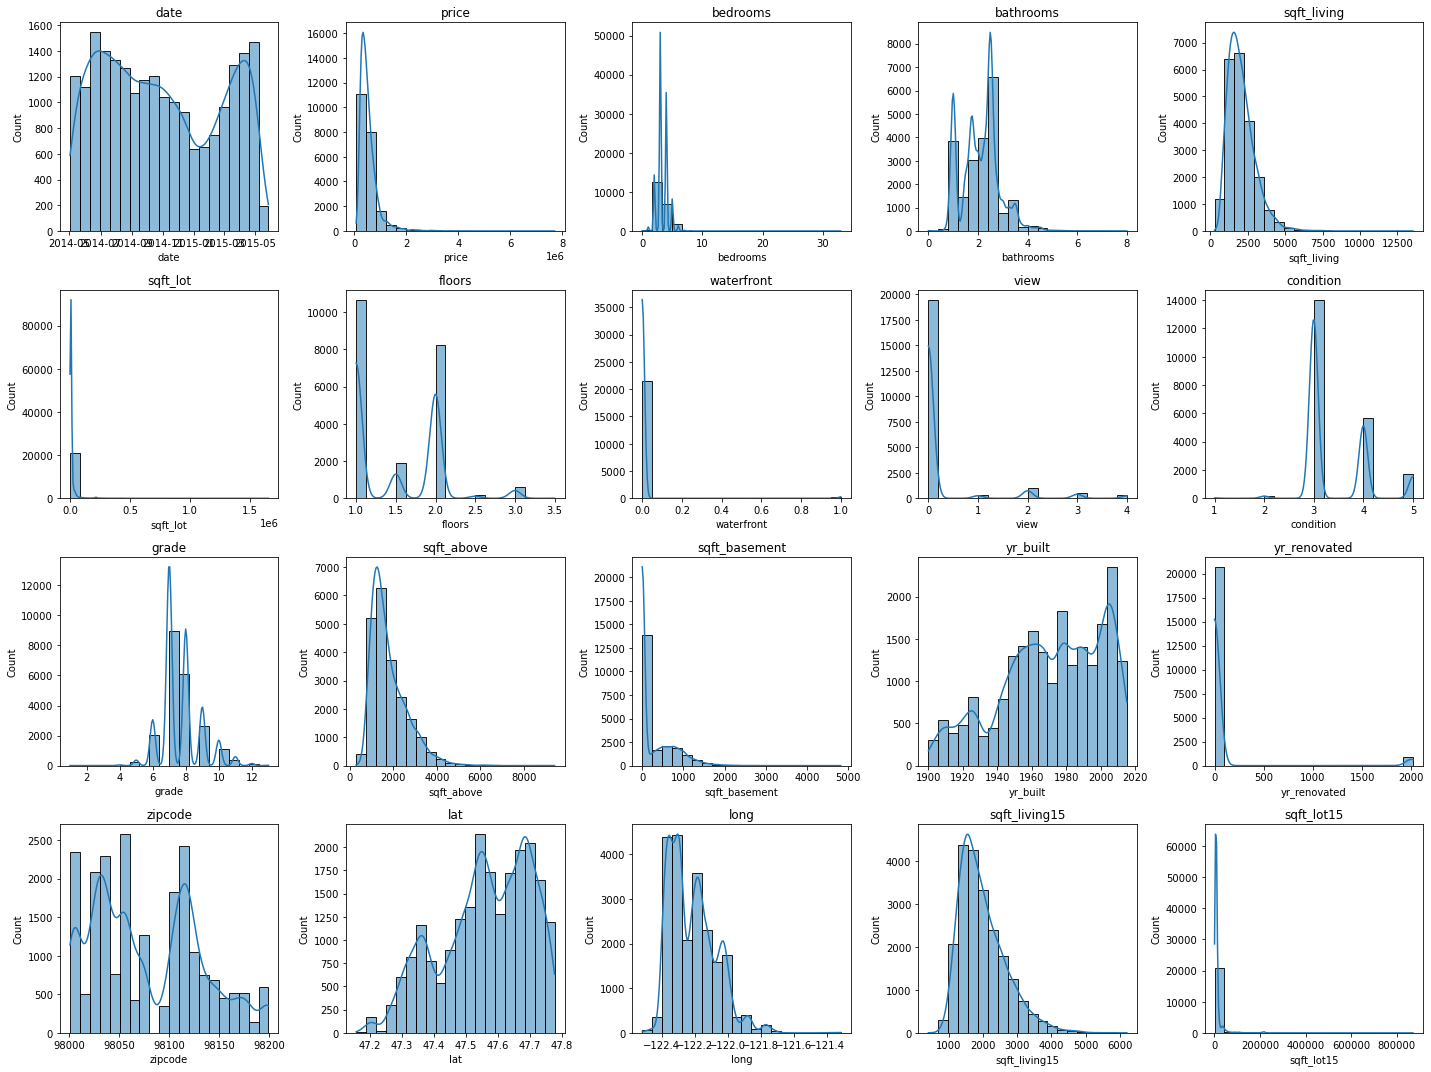

In [2]:
# PRE-PROCESSING

# load data and change date column datatype
df = pd.read_csv("kc_house_data.csv", parse_dates=['date'])
pd.set_option('display.max_columns', None)

# remove the id column
df.drop("id" , axis=1 , inplace=True)

# plot data correlations
plt.figure(figsize=(20, 15))
for feature in df.columns.to_list():
    plt.subplot(4, 5, df.columns.to_list().index(feature) + 1)
    sns.histplot(data=df[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# make yr_renovated = yr_built if zero
mask = df.yr_renovated==0
df.loc[mask, 'yr_renovated'] = df.yr_built

# drop date of sale, latitude, logitude data
df = df.drop(columns=['date', 'lat', 'long'])

# create a dummy variable for zipcode
# change datatype to string
convert_dict = {'zipcode': str}
df = df.astype(convert_dict)
df = pd.get_dummies(df)

# change observation with 33 bedrooms to 3 as it was probably a typo
df.loc[df.bedrooms == 33, 'bedrooms'] = 3

In [3]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,1360,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 86 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
 16  zipcode_98001  21613 non-null  uint8  
 17  zipcode_98002  21613 non-null  uint8  
 18  zipcod

In [5]:
df.shape

(21613, 86)

In [6]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
                ..
zipcode_98177    0
zipcode_98178    0
zipcode_98188    0
zipcode_98198    0
zipcode_98199    0
Length: 86, dtype: int64

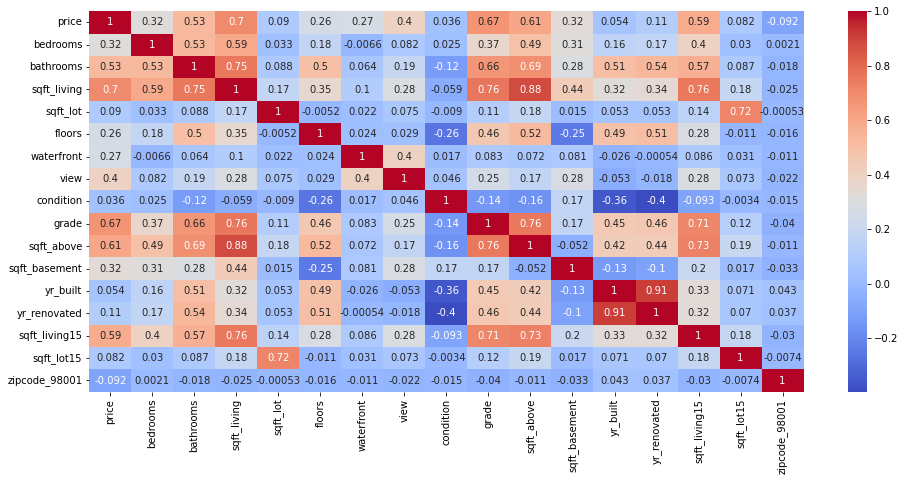

In [7]:
newdf = df[df.columns[:17]]
plt.figure(figsize=(16,7))
sns.heatmap(newdf.corr(), cmap='coolwarm', annot=True)
plt.show()

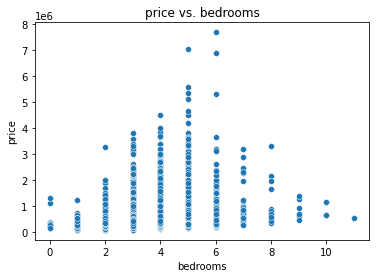

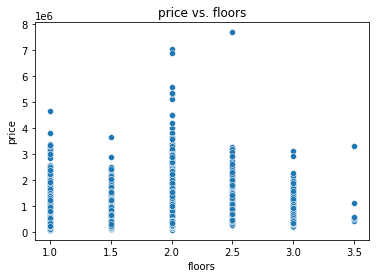

In [8]:
features = ['bedrooms', 'floors']

# fig, axs = plt.subplots(3, 5, figsize=(20, 16))
for i in range(len(features)):
    sns.scatterplot(x=features[i], y='price', data=df)
    t = f"price vs. {features[i]}"
    plt.title(t)
    plt.show()

# Part B: Model Development <a class="anchor" id="p2"></a>
[back to top](#top)

### Ordinary Least-Squares (OLS)

In [10]:
# OLS on full data set

# adjusted R-squared function
def adj_r2(X, r2):
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# Splitting the data
predictors = df[df.columns[1:]]
response = df['price']
A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Building and evaluating model
OLSmodel = LinearRegression()
OLSmodel.fit(A_train, b_train)
OLS_b_pred = OLSmodel.predict(A_test)
OLS_R2 = r2_score(b_test, OLS_b_pred)
OLS_adjusted_r2 = adj_r2(A_test, OLS_R2)
print('OLS Adj. R2:', OLS_adjusted_r2)

OLS Adj. R2: 0.8185293160845937


In [11]:
# Printing the first few OLS model coefficients
var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

list(zip(([OLSmodel.intercept_] + list(OLSmodel.coef_))[:15], var_names))

[(4480928.052883898, 'intercept'),
 (-31372.60573297181, 'bedrooms'),
 (25277.617357737963, 'bathrooms'),
 (14889023869856.953, 'sqft_living'),
 (0.26227633052932653, 'sqft_lot'),
 (-47463.20303200757, 'floors'),
 (692724.3504564388, 'waterfront'),
 (54118.68419183003, 'view'),
 (25060.73936785641, 'condition'),
 (55443.838788523426, 'grade'),
 (-14889023869639.043, 'sqft_above'),
 (-14889023869721.389, 'sqft_basement'),
 (-1266.3513107299805, 'yr_built'),
 (553.1044158935547, 'yr_renovated'),
 (8.99462890625, 'sqft_living15')]

### Subsetting data
Only using 500 of the available data points to illustrate how regularization methods can strongly improve model accuracy when working with little data.

In [12]:
# SUBSETTING DATA
predictors = df[df.columns[1:]]
response = df['price']

A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Selecting 500 random observations
np.random.seed(11)
rand_inds = np.random.randint(0,A_train.shape[0],500)

# subsetting data
A_train_subset = A_train.iloc[rand_inds]
b_train_subset = b_train.iloc[rand_inds]
A_train = A_train_subset
b_train = b_train_subset

OLSmodel = LinearRegression()
OLSmodel.fit(A_train, b_train)
OLS_b_pred = OLSmodel.predict(A_test)
OLS_R2 = r2_score(b_test, OLS_b_pred)
OLS_adjusted_r2 = adj_r2(A_test, OLS_R2)
print('OLS accuracy:', OLS_adjusted_r2)
print()

# Ridge
# standardize the data
scaler = StandardScaler()
scaler.fit(A_train)
stand_A_train= scaler.transform(A_train)
stand_A_test= scaler.transform(A_test)

alpha_range = np.linspace(10,100,10)
ridge_cv_model=RidgeCV(alphas=alpha_range, scoring='r2', cv=10)
ridge_cv_model.fit(stand_A_train, b_train)
y_preds = ridge_cv_model.predict(stand_A_test)
ridge_r2 = r2_score(b_test,y_preds)
print('Ridge accuracy:', adj_r2(A_test, ridge_r2))

OLS accuracy: 0.45294777258451224

Ridge accuracy: 0.7772816915235279


In [13]:
# Printing the first few new-OLS model coefficients 
var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

list(zip(([OLSmodel.intercept_] + list(OLSmodel.coef_))[:15], var_names))

[(-5080251.517885583, 'intercept'),
 (-42242.41652631034, 'bedrooms'),
 (55430.96360065928, 'bathrooms'),
 (8957643751953.463, 'sqft_living'),
 (1.4274614740657228, 'sqft_lot'),
 (-57918.10410272059, 'floors'),
 (145629.97966001192, 'waterfront'),
 (70326.00015534624, 'view'),
 (29886.241012314844, 'condition'),
 (46285.41666274066, 'grade'),
 (-8957643751755.867, 'sqft_above'),
 (-8957643751853.793, 'sqft_basement'),
 (-2119.1282119750977, 'yr_built'),
 (521.3529396057129, 'yr_renovated'),
 (52.50537109375, 'sqft_living15')]

### Ridge

In [14]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler

In [15]:
predictors = df[df.columns[1:]]
response = df['price']


A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Selecting 1000 random observations
np.random.seed(11)
rand_inds = np.random.randint(0,A_train.shape[0],500)

# subsetting data
A_train_subset = A_train.iloc[rand_inds]
b_train_subset = b_train.iloc[rand_inds]
A_train = A_train_subset
b_train = b_train_subset

# standardize the data
scaler = StandardScaler()
scaler.fit(A_train)
stand_A_train= scaler.transform(A_train)
stand_A_test= scaler.transform(A_test)

# set range of values for penalty parameter
alpha_range = np.linspace(118,125,10)

# train model and evaluate
ridge_cv_model=RidgeCV(alphas=alpha_range, scoring='r2', cv=10)
ridge_cv_model.fit(stand_A_train, b_train)
y_preds = ridge_cv_model.predict(stand_A_test)
ridge_r2 = r2_score(b_test,y_preds)
print('Ridge Adj. R2:', adj_r2(A_test, ridge_r2))
print()
print('Optimal gamma:', ridge_cv_model.alpha_)

Ridge Adj. R2: 0.7776012345942865

Optimal gamma: 123.44444444444444


In [16]:
# Printing the first few model coefficients 
var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']
list(zip(([ridge_cv_model.intercept_] + list(ridge_cv_model.coef_))[:15], var_names))

[(558351.1639999999, 'intercept'),
 (-17263.063983837077, 'bedrooms'),
 (37657.09218792877, 'bathrooms'),
 (61090.31864619402, 'sqft_living'),
 (31158.870737957463, 'sqft_lot'),
 (-4477.476967293826, 'floors'),
 (13284.179893357676, 'waterfront'),
 (47475.218927202615, 'view'),
 (13804.408579189903, 'condition'),
 (62315.497758317695, 'grade'),
 (61588.20776065258, 'sqft_above'),
 (8047.219641288361, 'sqft_basement'),
 (-38181.495833293986, 'yr_built'),
 (-12625.864482100014, 'yr_renovated'),
 (43457.81890314571, 'sqft_living15')]

### Lasso

In [17]:
from sklearn.linear_model import Lasso, LassoCV
import warnings
warnings.filterwarnings('ignore')

In [18]:
# split data
predictors = df[df.columns[1:]]
response = df['price']
A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Selecting 1000 random observations
np.random.seed(11)
rand_inds = np.random.randint(0,A_train.shape[0],500)

# subsetting data
A_train_subset = A_train.iloc[rand_inds]
b_train_subset = b_train.iloc[rand_inds]
A_train = A_train_subset
b_train = b_train_subset

# standardize the data
scaler = StandardScaler()
scaler.fit(A_train)
stand_A_train= scaler.transform(A_train)
stand_A_test= scaler.transform(A_test)

alpha_range = np.linspace(0, 100, 10)
lasso_cv = LassoCV(alphas = alpha_range, cv = 10)
lasso_cv.fit(stand_A_train, b_train)

y_preds = lasso_cv.predict(stand_A_test)
lasso_r2 = r2_score(b_test,y_preds)
print('Lasso Adj. R2: ', adj_r2(stand_A_test, lasso_r2))
print()
print('Optimal gamma:', lasso_cv.alpha_)

Lasso Adj. R2:  0.7522922305254829

Optimal gamma: 11.11111111111111


In [19]:
# Printing the first few model coefficients 
var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

list(zip(([lasso_cv.intercept_] + list(lasso_cv.coef_))[:15], var_names))

[(558351.164, 'intercept'),
 (-40047.28697447671, 'bedrooms'),
 (41478.349402771615, 'bathrooms'),
 (187193.3580627677, 'sqft_living'),
 (70536.12630046422, 'sqft_lot'),
 (-29295.04411188927, 'floors'),
 (13013.64737706249, 'waterfront'),
 (55824.880758814914, 'view'),
 (19798.44786239406, 'condition'),
 (55647.685634415255, 'grade'),
 (-10893.971640099953, 'sqft_above'),
 (-47131.076004496295, 'sqft_basement'),
 (-60921.87362888653, 'yr_built'),
 (14734.311521154432, 'yr_renovated'),
 (35348.74318724653, 'sqft_living15')]

### Elastic Net

In [20]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
import warnings
warnings.filterwarnings('ignore')

In [21]:
predictors = df[df.columns[1:]]
response = df['price']

A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Selecting 1000 random observations
np.random.seed(11)
rand_inds = np.random.randint(0,A_train.shape[0],500)

# subsetting data
A_train_subset = A_train.iloc[rand_inds]
b_train_subset = b_train.iloc[rand_inds]
A_train = A_train_subset
b_train = b_train_subset

# standardize the data
scaler = StandardScaler()
scaler.fit(A_train)
stand_A_train= scaler.transform(A_train)
stand_A_test= scaler.transform(A_test)

# set range of values for penalty parameter
alpha_range = np.linspace(0, 100, 10)

elastic_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=alpha_range, cv = 10)
elastic_net_cv.fit(A_train, b_train)

ElasticNetCV(alphas=array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ]),
             cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1])

In [22]:
elastic_net_cv.fit(stand_A_train, b_train)
y_preds = elastic_net_cv.predict(stand_A_test)
e_net_r2 = r2_score(b_test,y_preds)
print('Elastic Net Adj. R2:', adj_r2(A_test, e_net_r2))
print()
print('Optimal alpha:', elastic_net_cv.alpha_)
print()
print('Optimal l1_ratio:', elastic_net_cv.l1_ratio_)

Elastic Net Adj. R2: 0.7775168060628193

Optimal alpha: 22.22222222222222

Optimal l1_ratio: 0.99


In [23]:
var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

list(zip(([elastic_net_cv.intercept_] + list(elastic_net_cv.coef_))[:15], var_names))

[(558351.1639999999, 'intercept'),
 (-18580.521652791947, 'bedrooms'),
 (38035.10895922016, 'bathrooms'),
 (62030.47088519699, 'sqft_living'),
 (32331.055266026717, 'sqft_lot'),
 (-5597.794800375797, 'floors'),
 (13247.156175308228, 'waterfront'),
 (48069.76285641636, 'view'),
 (14165.780949160133, 'condition'),
 (62689.584349414385, 'grade'),
 (62693.393708310876, 'sqft_above'),
 (7779.600507272035, 'sqft_basement'),
 (-39143.67530312682, 'yr_built'),
 (-12015.373539375756, 'yr_renovated'),
 (43221.04761356589, 'sqft_living15')]

# Part C: Numerical Stability Experiment <a class="anchor" id="p3"></a>
[back to top](#top)
### Condition number exercise OLS
I create a copy of our data, and slightly perturb the data to see how it changes the resulting coefficients. This illustrates the issues that arise when computing with a matrix which has a large condition number. 

In [24]:
# Splitting the data
predictors = df[df.columns[1:]]
response = df['price']
A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# Observe the large condition number
cond_num = np.linalg.cond(A_train.transpose()@A_train)
print('Condition number: ', cond_num)
print()

# create a copy for perturbations
new_train = A_train.copy()
np.random.seed(11)
play_inds = np.random.randint(0,new_train.shape[0],20)
print("before perturbations")
print(new_train.iloc[play_inds[:6], [2,12]])
print()

# adding 10 sqft to 500 houses
new_train.iloc[play_inds, [2]] =  new_train.iloc[play_inds, [2]] + 10
# adding 1 to yr_renovated 500 houses
new_train.iloc[play_inds, [12]] =  new_train.iloc[play_inds, [12]] + 1
print("after perturbations")
print(new_train.iloc[play_inds[:6], [2,12]])
print()

new_OLSmodel = LinearRegression()
new_OLSmodel.fit(new_train, b_train)

OLSmodel = LinearRegression()
OLSmodel.fit(A_train, b_train)

var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']
print('Perturbed model coefficients')
print(list(zip(([new_OLSmodel.intercept_] + list(new_OLSmodel.coef_))[:15], var_names)))
print()
print('Original model coefficients')
print(list(zip(([OLSmodel.intercept_] + list(OLSmodel.coef_))[:15], var_names)))

Condition number:  5.443581147001386e+17

before perturbations
       sqft_living  yr_renovated
14901         1330          1950
8372          1840          1958
13988         2740          1984
17819         1230          1911
10706         2820          1957
10118         2110          1978

after perturbations
       sqft_living  yr_renovated
14901         1340          1951
8372          1850          1959
13988         2750          1985
17819         1240          1912
10706         2830          1958
10118         2120          1979

Perturbed model coefficients
[(-191121447968.5451, 'intercept'), (-31231.826882782374, 'bedrooms'), (25094.502035497473, 'bathrooms'), (-5519.304355243627, 'sqft_living'), (0.26447704331445365, 'sqft_lot'), (-47566.85063048579, 'floors'), (692835.7819136857, 'waterfront'), (54036.21569002603, 'view'), (25141.02726230862, 'condition'), (55520.73579245618, 'grade'), (5737.115827879345, 'sqft_above'), (5654.768008026702, 'sqft_basement'), (-1270.451449

### Condition number exercise Ridge
I create a copy of our data, and slightly perturb the data to see how it changes the resulting coefficients. We observe below in the manual implementation how the condition number is smaller when using Ridge. 

In [25]:
# Splitting the data
predictors = df[df.columns[1:]]
response = df['price']
A_train, A_test, b_train, b_test = train_test_split(predictors, response, train_size=.8, random_state=11)

# create a copy for perturbations
new_train = A_train.copy()
np.random.seed(11)
play_inds = np.random.randint(0,new_train.shape[0],20)
print("before perturbations")
print(new_train.iloc[play_inds[:6], [2,12]])
print()

# adding 10 sqft to 500 houses
new_train.iloc[play_inds, [2]] =  new_train.iloc[play_inds, [2]] + 10
# adding 1 to yr_renovated 500 houses
new_train.iloc[play_inds, [12]] =  new_train.iloc[play_inds, [12]] + 1
print("after perturbations")
print(new_train.iloc[play_inds[:6], [2,12]])
print()

# standardize the data
scaler = StandardScaler()
scaler.fit(A_train)
stand_A_train= scaler.transform(A_train)

scaler2 = StandardScaler()
scaler2.fit(new_train)
stand_new_train= scaler2.transform(new_train)

alpha_range = np.linspace(118,125,10)

# create model with original data
ridge_cv_model=RidgeCV(alphas=alpha_range, scoring='r2', cv=10)
ridge_cv_model.fit(stand_A_train, b_train)

# create model with perturbed data
new_ridge_cv_model=RidgeCV(alphas=alpha_range, scoring='r2', cv=10)
new_ridge_cv_model.fit(stand_new_train, b_train)

var_names = ['intercept', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']
print('Original model coefficients')
print(list(zip(([ridge_cv_model.intercept_] + list(ridge_cv_model.coef_))[:15], var_names)))
print()
print('Perturbed model coefficients')
print(list(zip(([new_ridge_cv_model.intercept_] + list(new_ridge_cv_model.coef_))[:15], var_names)))

before perturbations
       sqft_living  yr_renovated
14901         1330          1950
8372          1840          1958
13988         2740          1984
17819         1230          1911
10706         2820          1957
10118         2110          1978

after perturbations
       sqft_living  yr_renovated
14901         1340          1951
8372          1850          1959
13988         2750          1985
17819         1240          1912
10706         2830          1958
10118         2120          1979

Original model coefficients
[(541689.2580104106, 'intercept'), (-27623.172924328206, 'bedrooms'), (20051.390340986603, 'bathrooms'), (92335.31326059911, 'sqft_living'), (10657.35701181278, 'sqft_lot'), (-24264.247707396175, 'floors'), (59712.782830574535, 'waterfront'), (41400.384406087185, 'view'), (15994.688914996934, 'condition'), (65988.8155130906, 'grade'), (94497.45254719163, 'sqft_above'), (15336.361070346662, 'sqft_basement'), (-36057.89696776475, 'yr_built'), (13781.842911615115, '

### K-Fold Cross Validation manual implementation

In [26]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,1360,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# add a column of ones
ones = np.ones(df.shape[0])
df['ones'] = ones
cols = df.columns.tolist()
cols = cols[0:1] + cols[-1:] + cols[1:-1]
df = df[cols]
df.head()

,price,ones,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,1.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,538000.0,1.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.0,1.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.0,1.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,1360,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,510000.0,1.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Cross validation

# reserve 10% of the data as a holdout, for testing final model
np.random.seed(11)
holdout_size = round(df.shape[0]*.1)
rand_inds = np.random.randint(0,df.shape[0],holdout_size)
holdout_data = df.iloc[rand_inds]

# remove holdout from data, will use this subset of data for cross-validation
train_folds = df.drop(list(rand_inds), axis=0, inplace=False)

# build K models for each gamma 
gammas = np.linspace(0,1,11)
gamma_adj_r2_lst = []
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 11)
for gamma in gammas:
    adj_r2_lst = []
    for train_ind, test_ind in kf.split(train_folds):
#         print(sum(train_ind)) # can show that each training set is different
#         print(sorted(list(train_ind)+list(test_ind)) == list(range(df.shape[0]))) # can show that the training and testing sets combine to equal the whole df
        
        train = df.iloc[train_ind,:]
        test = df.iloc[test_ind,:]

        b = train.price.to_numpy()
        A = train.drop(columns = 'price').to_numpy()
        coeffs = inv(A.transpose()@A + gamma * np.identity(86)) @ (A.transpose() @ b)

        test_prices = test.price.to_numpy()
        test_mat = test.drop(columns = 'price').to_numpy()
        price_preds = test_mat @ coeffs
        # Calculate the adjusted R-squared
        r_squared = 1 - (np.sum((test_prices - price_preds)**2) / np.sum((test_prices - np.mean(test_prices))**2))
        n = len(test_prices)
        num_predictors = (len(coeffs)-1)
        adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - num_predictors - 1))
        adj_r2_lst.append(adjusted_r_squared)
    
    avg_adj_r2 = sum(adj_r2_lst)/len(adj_r2_lst)
    gamma_adj_r2_lst.append((gamma,avg_adj_r2))
    
    
# select optimal gamma corresponding to largest avg_adj_r2
min_tuple = max(gamma_adj_r2_lst, key=lambda t: t[1])
opt_gamma = min_tuple[0]

# now that we have our optimal value of gamma, we can build a new model, using all of the training folds, and test 
    # this optimal model on our holdout data to get an idea of its accuracy
train = train_folds
test = holdout_data
b = train.price.to_numpy()
A = train.drop(columns = 'price').to_numpy()
coeffs = inv(A.transpose()@A + opt_gamma * np.identity(86)) @ (A.transpose() @ b)
test_prices = test.price.to_numpy()
test_mat = test.drop(columns = 'price').to_numpy()
price_preds = test_mat @ coeffs
# Calculate the adjusted R-squared
r_squared = 1 - (np.sum((test_prices - price_preds)**2) / np.sum((test_prices - np.mean(test_prices))**2))
n = len(test_prices)
num_predictors = (len(coeffs)-1)
best_model_adj_r2 = 1 - ((1 - r_squared) * (n - 1) / (n - num_predictors - 1))


In [29]:
gamma_adj_r2_lst

[(0.0, -5536.619248515121),
 (0.1, 0.7946195253368777),
 (0.2, 0.7946232194659312),
 (0.30000000000000004, 0.7946164610055418),
 (0.4, 0.7946055140921696),
 (0.5, 0.7945951619665131),
 (0.6000000000000001, 0.794584671450255),
 (0.7000000000000001, 0.7945705988272611),
 (0.8, 0.79455701496858),
 (0.9, 0.794542932288902),
 (1.0, 0.7945308326326094)]

We can see above that even a small penalization parameter value will lead to a large increase in model accuracy compared to OLS.

In [30]:
# Observe the ridge condition number
num = np.linalg.cond(A.transpose()@A + opt_gamma * np.identity(86))
num

247138314270060.22

In [31]:
from decimal import Decimal

'%.2E' % Decimal(14889023869856.953)

'1.49E+13'